Device = cpu
Time for first sim: 0.2017667293548584 s
znorm smooth: 0.13235732913017273 rand: 0.9674376845359802 ratio: 7.309286844134717
done


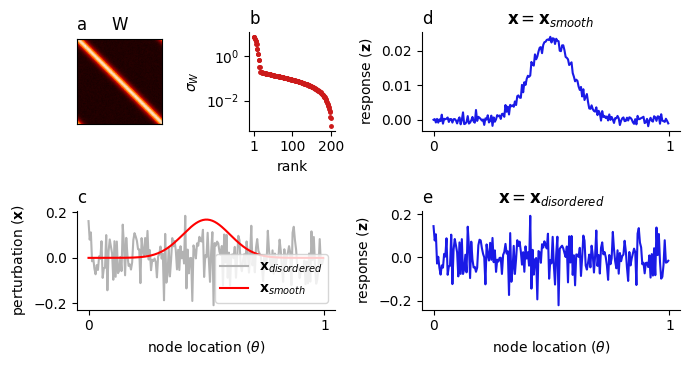

In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from time import time as tm

import torch 
from models import RateModel
from utils import ToNP, MakeSmoothGaussianProcess, TorchPCA

# The SVD calc takes a long time to run (about 2 minutes on a macbook M2)
# Set this flag to False if you want to load the pre-computed SVD vals.
RunSVD=False

# Save figures?
SaveFigs=True

# Choose a device
if torch.cuda.is_available():
    device = 'cuda'
elif torch.backends.mps.is_available():
    device = 'mps'
else:
    device = 'cpu'
device='cpu'
print('Device =',device)

torch.manual_seed(1)

# Number of neurons in recurrent net
N = 200

# Duration of simulation in ms
T = 100
dt = 0.01
time = np.arange(0,T,dt)
Nt = len(time)



# Parameters for connectivity matrix
c=-.5
rho=0.1

cx=1

sigmaw=0.05
sigmax=0.1


# Time step size, timescale of dynamics
dt = 0.01
tau=1



# Connectivity

# Compute pairwise differences between all pairs of
# values in the vectors x and y
def PairwiseDifferences(x,y):
    return x.unsqueeze(1) - y

# Univariate Gaussian pdf
def Gaussian(x,mu,sigma):
    sqrt2pi = 2.5066282746310002
    return torch.exp(-(x-mu)**2/(2*sigma**2))/(sigma*sqrt2pi)

# Univariate wrapped Gaussian on [0,1)
def WrappedGaussian(x,mu,sigma,num_wraps):
    g=0
    for w in range(-num_wraps,num_wraps+1):
        g += Gaussian(x+w,mu,sigma)
    return g

theta=(torch.tensor(range(N))/N).to(device)

W0 = c*WrappedGaussian(PairwiseDifferences(theta,theta),0,sigmaw,2)/np.sqrt(N)


W1 = rho*torch.randn(N,N).to(device)/np.sqrt(N)
W = W0 + W1


# Coefficient for RNN Euler integrator
eta = dt/tau

# Model and random model
model = RateModel(W, f='tanh', eta = eta, bias_recurrent=False, Network_Type='Z').to(device)

# singular values and eigenvalues of connectivity
with torch.no_grad():
    sigmaW = torch.linalg.svdvals(W.cpu())
    lamW = torch.linalg.eigvals(W.cpu())
    #print('max real e-val of W:',torch.real(lamW).max().item())



usmooth = WrappedGaussian(theta,0.5,sigmax,2)
usmooth = usmooth/usmooth.norm()

urand = torch.randn(N)
urand = urand/urand.norm()


x = torch.zeros(2, N).to(device)
x[0,:] = cx*usmooth
x[1,:] = cx*urand


# Run simulation
t0=tm()
with torch.no_grad():
    r = model(x, Nt=Nt, return_time_series = False, store_hidden_history = False, initial_state=(.1/np.sqrt(N))*torch.randn(N).to(device) )
    z = model.hidden_state
    y = model.recurrent_layer(r)
    tSim1=tm()-t0
    print('Time for first sim:',tSim1,'s')


print('znorm smooth:',z[0,:].norm().item(),'rand:',z[1,:].norm().item(),'ratio:',z[1,:].norm().item()/z[0,:].norm().item())


### Make Figure 1
xclr = [.1,.6,.1]
yclr = [.7,.2,.7]
zclr = [.1,.1,.9]
Wclr = [.8,.1,.1]

numplot = N


fig, axes = plt.subplot_mosaic("abdd;ccee",figsize=(7,3.75))



####### PANEL A ######
c0='a'
ax0 = axes[c0]
im = ax0.imshow(ToNP(W), cmap='gist_heat_r')
#cbar = fig.colorbar(im, ax=ax0)
#cbar.set_ticks([-0.2,0,0.2])
#cax = fig.add_axes([ax0.get_position().x1,ax0.get_position().y0,0.02,ax0.get_position().height])
#plt.colorbar(im, cax=cax) # Similar to fig.colorbar(im, cax = cax)
#cbar = fig.colorbar(im, cax = cax)
#cbar.set_ticks([-1,0,1])
ax0.set_title('W')
ax0.set_xticks([])
ax0.set_yticks([])
#ax0.set_ylabel('W')
ax0.set_title(c0,loc='left')

####### PANEL B ###### 
c0='b'
ax0 = axes[c0]
ax0.plot(np.arange(N)+1,ToNP(sigmaW),'.',markersize=5, color=Wclr)
#ax0.set_ylim([0,1.1])
ax0.set_xlim([-10,N+10])
#ax0.set_yticks([0,.5,1])
ax0.set_xticks([1,int(N/2),N])
ax0.set_xlabel('rank')
ax0.set_ylabel(r'$\sigma_W$')
ax0.set_yscale('log')
ax0.set_title(c0,loc='left')
sns.despine(ax=ax0)


c0='c'
ax0 = axes[c0]
ax0.plot(np.arange(N)/N,urand,color=[.7,.7,.7],label=r'${\bf x}_{disordered}$')
ax0.plot(np.arange(N)/N,usmooth,color='r',label=r'${\bf x}_{smooth}$')
ax0.set_xlabel(r'node location $(\theta)$')
ax0.set_xticks([0, 1])
ax0.set_ylabel(r'perturbation ($\bf x$)')
ax0.legend(loc='lower right')
ax0.set_title(c0,loc='left')
sns.despine(ax=ax0)


c0='d'
ax0 = axes[c0]
ax0.plot(np.arange(N)/N,z[0,:], color=zclr)
ax0.set_ylabel(r'response ($\bf z$)')
ax0.set_xticks([0, 1])
#ax0.set_xlabel(r'node location $(\theta)$')
ax0.set_title(r'${\bf x}={\bf x}_{smooth}$')
ax0.set_title(c0,loc='left')
sns.despine(ax=ax0)

c0='e'
ax0 = axes[c0]
ax0.plot(np.arange(N)/N,z[1,:], color=zclr)
ax0.set_ylabel(r'response ($\bf z$)')
ax0.set_xticks([0, 1])
ax0.set_xlabel(r'node location $(\theta)$')
ax0.set_title(r'${\bf x}={\bf x}_{disordered}$')
ax0.set_title(c0,loc='left')
sns.despine(ax=ax0)



fig.tight_layout()


if SaveFigs:
    fig.savefig('./Figures/Figure5.pdf')
    fig.savefig('./Figures/Figure5unpolished.svg')
print('done')



